In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import re
import pickle
from function_library import *
from function_library2 import *

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


## Find out all the people related in Edison project

In [2]:
# load people list from pickle
# maybe should save body and title into pickle as well?
l_from = fromPickle("from_list")
l_to   = fromPickle("to_list")
l_cc   = fromPickle("cc_list")

In [3]:
# load df with body
df = pd.read_csv('output4.csv')
df['Sent'] = pd.to_datetime(df['Sent'])
df = df[df['Sent'] > datetime( 2012, 1, 1, 0, 0, 0)]
body = df['Body'].values
subject = df['Subject'].values

In [4]:
# if edison appear in the subject or the body, save the index
# GE: you can probably get faster execution using the pd.apply function
edison = 'edison'
idx_list = []
for idx in range(len(body)):
    if edison in body[idx].lower() or edison in subject[idx].lower():
        idx_list.append(idx)

In [5]:
# find all the senders using the index list 
from_list = standardize_triplet(np.array(l_from)[idx_list].tolist())
name_list = set(from_list)

# find all the recipients using the index list 
to_list = standardize_triplet(np.array(l_to)[idx_list].tolist())
for names in to_list:
    # GE: I do not follow the logic
    name_list |= set(names)
cc_list = standardize_triplet(np.array(l_cc)[idx_list].tolist())
for names in cc_list:
    name_list |= set(names)

# convert to list and sort, in order to save to a txt
name_list = list(name_list)
name_list.sort()
#name_list[0:5]

In [6]:
# save to a text file
# GE: person[i] is the triplet (first name, last name, email)
# GE: person[0] is ('','',''). Is this always true? Or does it depend on the data? 
# GE:    if not always true, the code below will not always work.
with open('edison_people_list.txt', 'w') as filehandle:
    for person in name_list[1:]:
        filehandle.write('{} {}: {}\n'.format(person[0], person[1], person[2]))

## Pick out all the related emails

In [7]:
# pick out all the related emails and save into another csv
# GE: make sure you explain to our team what criteria you used to extract Edison-related emails
# Joey: If the key word 'Edison' shows in the title or the body, then the email is considered to be Edison-related

df_edison = df.iloc[idx_list]

# GE: Why are there 'Unnamed: 0' in df_edison? I thought we had cleaned up the emails
# GE: to make sure these columns do not appear, you must use pd.read_csv and/or df.to_csv
# GE: with an additional argument: 
del df_edison['Unnamed: 0']
del df_edison['Unnamed: 0.1']

df_edison.to_csv('edison_emails.csv')
#df_edison.head(50)

In [8]:
# number of emails related 
len(idx_list)

1028

## Find abnormal action by looking at sending time
* **All emails are used**  
* **The sending time is divided into 4 ranges. The idea is to focus on the emails sent outside regular work hours**  

In [9]:
# identify the sending time in 4 time ranges
l_hour = fromPickle("hour_list")
l_hour_partition = []
for hour in l_hour:
    if hour>=4 and hour<=7:
        l_hour_partition.append(1)
    elif hour>=8 and hour<=16:
        l_hour_partition.append(2)
    elif hour>=17 and hour<=20:
        l_hour_partition.append(3)
    else:
        l_hour_partition.append(4)
toPickle(l_hour_partition, 'hour_partition')       

In [10]:
l_year = fromPickle("year_list")
l_week = fromPickle("week_list")
l_month = fromPickle("month_list")
l_dayofyear = fromPickle("dayofyear_list")

In [11]:
# create a matrix, #year by #day by #time_range+1
# GE: what do the dimensions of hour_range_by_day represent?
# Joey: First dimension is year. So I give it 6. Second dimension is day. So I give it 366. Last dimension is the 4 time ranges plus a summation.
hour_range_by_day = np.zeros((6,366,5))
for i in range(len(l_hour_partition)):
    ix = l_year[i]-2012
    iy = l_dayofyear[i]-1
    iz = l_hour_partition[i]-1
    # GE: explain the next two lines.
    # Joey: first line add 1 at the corresponding time. Second line add 1 to the summation
    hour_range_by_day[ix,iy,iz] += 1    
    hour_range_by_day[ix,iy,4] += 1

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/joey/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/joey/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


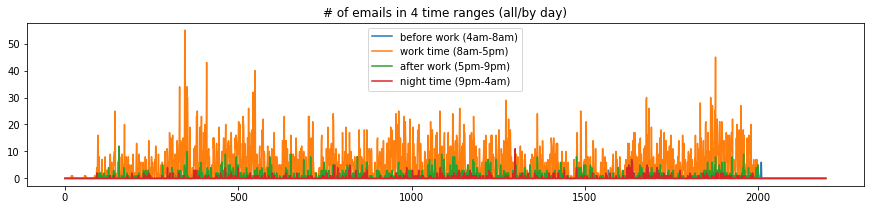

/Users/joey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


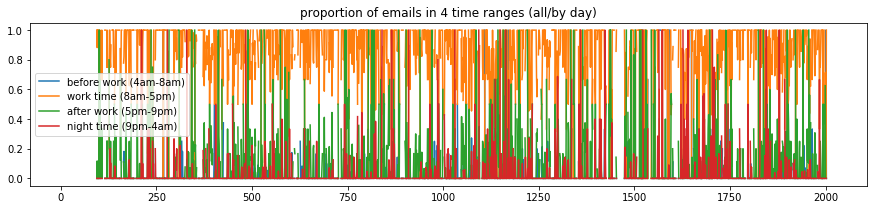

In [12]:
time_range_labels = ['before work (4am-8am)','work time (8am-5pm)', 'after work (5pm-9pm)', 'night time (9pm-4am)']

plt.figure(figsize = (15,3))
for i in range(4):
    # GE: why are the first two indices of hour_range_by_dan?
    # Joey: First dimension is year. So I give it 6. Second dimension is day. So I give it 366
    
    temp = np.reshape(hour_range_by_day[:,:,i], -1)
    plt.plot(temp, label = time_range_labels[i])
plt.legend()
plt.title('# of emails in 4 time ranges (all/by day)')
plt.show()

hour_partition_sum = np.reshape(hour_range_by_day[:,:,4], -1)
plt.figure(figsize = (15,3))
for i in range(4):
    temp = np.reshape(hour_range_by_day[:,:,i], -1)
    plt.plot(temp/hour_partition_sum, label = time_range_labels[i])
plt.legend()
plt.title('proportion of emails in 4 time ranges (all/by day)')
plt.show()


**Using day as the base unit may be too dense. 12000 emails in 2000 days, six per day in average.**  
**So I try to use a weekly scale below**

In [13]:
# create a matrix, #year by #week by #time_range+1
hour_range_by_week = np.zeros((6,52,5))
for i in range(len(l_hour_partition)):
    ix = l_year[i]-2012
    iy = l_week[i]-1
    iz = l_hour_partition[i]-1
    if iy == 52:
        continue
    hour_range_by_week[ix,iy,iz] += 1   # GE: iz = 0,1,2,3
    hour_range_by_week[ix,iy,4] += 1 # GE: what is this for?


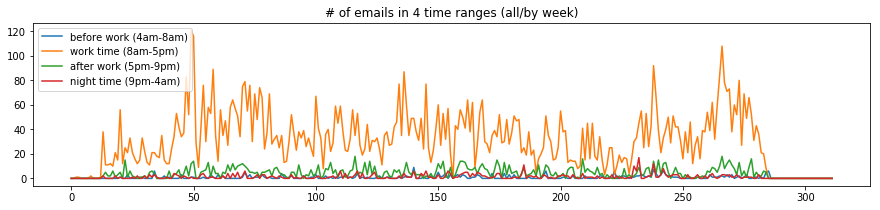

/Users/joey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


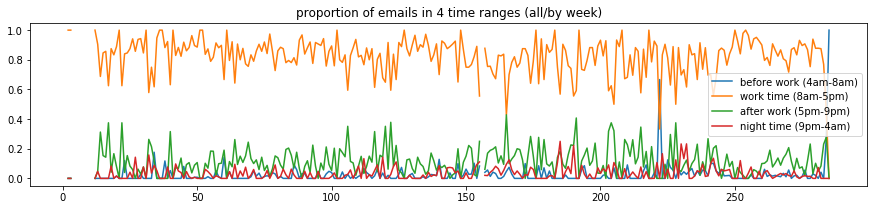

In [14]:
plt.figure(figsize = (15,3))
for i in range(4):
    temp = np.reshape(hour_range_by_week[:,:,i], -1)
    plt.plot(temp, label = time_range_labels[i])
plt.legend()
plt.title('# of emails in 4 time ranges (all/by week)')
plt.show()

hour_partition_sum = np.reshape(hour_range_by_week[:,:,4], -1)
plt.figure(figsize = (15,3))
for i in range(4):
    temp = np.reshape(hour_range_by_week[:,:,i], -1)
    plt.plot(temp/hour_partition_sum, label = time_range_labels[i])
plt.legend()
plt.title('proportion of emails in 4 time ranges (all/by week)')
plt1 = plt
plt.show()


## Only apply on Edison emails

In [15]:
df = pd.read_csv('edison_emails.csv')
df['Sent'] = pd.to_datetime(df['Sent'])
del df['Unnamed: 0']
df['year']    = df['Sent'].dt.year
df['month']   = df['Sent'].dt.month
df['week']    = df['Sent'].dt.week
df['weekday'] = df['Sent'].dt.weekday
df['day'] = df['Sent'].dt.day
df['dayofyear'] = df['Sent'].dt.dayofyear
df['hour']    = df['Sent'].dt.hour
# df.head()

In [16]:
# identify the sending time in 4 time ranges
l_hour = df['hour'].tolist()
l_hour_partition = []
for hour in l_hour:
    if hour>=4 and hour<=7:
        l_hour_partition.append(1)
    elif hour>=8 and hour<=16:
        l_hour_partition.append(2)
    elif hour>=17 and hour<=20:
        l_hour_partition.append(3)
    else:
        l_hour_partition.append(4)
toPickle(l_hour_partition, 'hour_partition')       

In [17]:
l_year = df['year'].tolist()
l_week = df['week'].tolist()
l_month = df['month'].tolist()
l_dayofyear = df['dayofyear'].tolist()

In [18]:
# create a matrix, #year by #day by #time_range+1
hour_range_by_day = np.zeros((6,366,5))
for i in range(len(l_hour_partition)):
    ix = l_year[i]-2012
    iy = l_dayofyear[i]-1
    iz = l_hour_partition[i]-1
    hour_range_by_day[ix,iy,iz] += 1    
    hour_range_by_day[ix,iy,4] += 1

In [36]:
hour_partition_sum = np.reshape(hour_range_by_day[:,:,4], -1)
boundaries = np.nonzero(hour_partition_sum)[0][np.array([0,-1])]
# boundaries

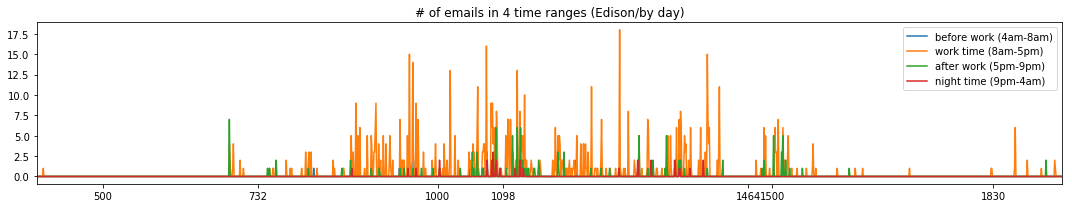

/Users/joey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


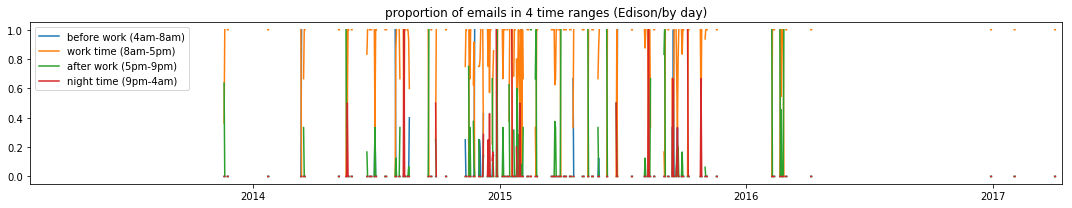

In [35]:
hour_partition_sum = np.reshape(hour_range_by_day[:,:,4], -1)

plt.figure(figsize = (15,3))
for i in range(4):
    temp = np.reshape(hour_range_by_day[:,:,i], -1)
    plt.plot(temp, label = time_range_labels[i])
plt.legend()
plt.xticks(list(plt.xticks()[0])+np.linspace(0,366*6,7).tolist(), )
plt.xlim(boundaries[0]-10,boundaries[1]+10)
plt.title('# of emails in 4 time ranges (Edison/by day)')
plt.tight_layout()
plt.show()

hour_partition_sum = np.reshape(hour_range_by_day[:,:,4], -1)
plt.figure(figsize = (15,3))
for i in range(4):
    temp = np.reshape(hour_range_by_day[:,:,i], -1)
    plt.plot(temp/hour_partition_sum, label = time_range_labels[i])
plt.legend()
plt.xticks(np.linspace(0,366*6,7), ['2012','2013','2014','2015','2016','2017','2018'])
plt.xlim(boundaries[0]-10,boundaries[1]+10)
plt.title('proportion of emails in 4 time ranges (Edison/by day)')
plt.tight_layout()

plt.show()


In [22]:
# create a matrix, #year by #week by #time_range+1
hour_range_by_week = np.zeros((6,52,5))
for i in range(len(l_hour_partition)):
    ix = l_year[i]-2012
    iy = l_week[i]-1
    iz = l_hour_partition[i]-1
    if iy == 52:
        continue
    hour_range_by_week[ix,iy,iz] += 1    
    hour_range_by_week[ix,iy,4] += 1


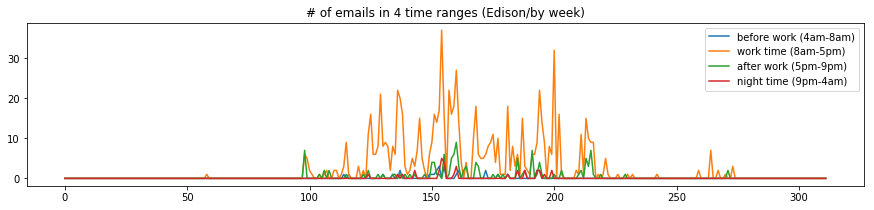

/Users/joey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


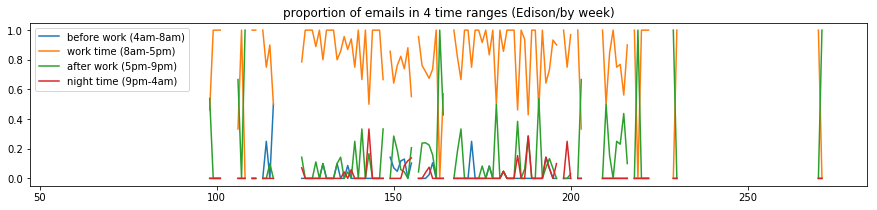

In [23]:
plt.figure(figsize = (15,3))
for i in range(4):
    temp = np.reshape(hour_range_by_week[:,:,i], -1)
    plt.plot(temp, label = time_range_labels[i])
plt.legend()
plt.title('# of emails in 4 time ranges (Edison/by week)')
plt.show()

hour_partition_sum = np.reshape(hour_range_by_week[:,:,4], -1)
plt.figure(figsize = (15,3))
for i in range(4):
    temp = np.reshape(hour_range_by_week[:,:,i], -1)
    plt.plot(temp/hour_partition_sum, label = time_range_labels[i])
plt.legend()
plt.title('proportion of emails in 4 time ranges (Edison/by week)')
plt.show()


## Exploring style analysis using POS

In [24]:
df = pd.read_csv('new_clean_output.csv')
df['Sent'] = pd.to_datetime(df['Sent'])
df = df[df['Sent'] > datetime( 2012, 1, 1, 0, 0, 0)]
df.head()

,Unnamed: 0,From,Sent,To,CC,Subject,Attachments,Body,title_length_c,title_length_w,body_length_w,POS,POS_dict
0,1091,"['Heiter, Deborah [mailto:Deborah.Heiter@talgo...",2012-01-20 16:41:00,"[""Behenna, Bill; Branch, Cathy; Burn, Paula; C...",[],['Economic Development Target Issue Meeting'],[],"['', '', '', 'Deborah L. Heiter', 'Administrat...",41,5,31,"['NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'PRP', 'NN...","{'NNP': 24, 'PRP': 1, 'IN': 1, 'CD': 5, ',': 2..."
1,1092,['Beth Kirkland [mailto:bkirkland@taledc.com]'],2012-01-23 09:32:00,"[""'llaubscher@eflorida.com'""]","[""brook.pace@deo.myflorida.com; Kim Rivers(kim...",['City of Tallahassee meeting regarding SBCI'],[],"['', 'Louis,', '', 'Thank you for meeting with...",42,6,180,"['NNP', ',', 'NNP', 'PRP', 'IN', 'VBG', 'IN', ...","{'NNP': 63, ',': 11, 'PRP': 8, 'IN': 17, 'VBG'..."
2,1093,"['Wiebler, Brian T.']",2012-02-27 10:04:00,[],[],['Rural Density'],[],"['', '', '']",13,2,0,[],{}
3,1094,"['Wiebler, Brian T.']",2012-03-01 15:51:00,"['Wiebler, Brian T.']",[],['Update on Rural Density Comprehensive Plan T...,[],"['', 'Thank you for your interest in the upcom...",69,9,182,"['NNP', 'PRP', 'IN', 'PRP$', 'NN', 'IN', 'DT',...","{'NNP': 25, 'PRP': 10, 'IN': 17, 'PRP$': 3, 'N..."
4,1095,"['Wiebler, Brian T.']",2012-03-27 15:59:00,"['Wiebler, Brian T.']",[],['Rural Density Comprehensive Plan Text Amendm...,[],"['', 'This is a reminder of the open house eve...",59,7,400,"['DT', 'VBZ', 'DT', 'NN', 'IN', 'DT', 'JJ', 'N...","{'DT': 38, 'VBZ': 7, 'NN': 55, 'IN': 35, 'JJ':..."


In [25]:
df_pos = pd.read_csv('pos_counts.csv')
del df_pos['Unnamed: 0']
df_pos_edison = df_pos.iloc[idx_list]
unique_pos_tags = df_pos_edison.columns
df_pos_edison.head()

,$,'',(,),",",.,:,CC,CD,DT,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
1769,1.0,0.0,81.0,81.0,2720.0,608.0,590.0,599.0,889.0,1399.0,...,478.0,302.0,432.0,411.0,399.0,225.0,100.0,79.0,0.0,42.0
3753,1.0,0.0,0.0,0.0,6.0,4.0,1.0,2.0,8.0,8.0,...,7.0,2.0,4.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0
3754,1.0,0.0,0.0,0.0,6.0,4.0,1.0,2.0,8.0,8.0,...,7.0,2.0,4.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0
3755,0.0,0.0,1.0,1.0,1.0,8.0,2.0,2.0,2.0,4.0,...,6.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0
3759,0.0,0.0,1.0,1.0,1.0,8.0,2.0,4.0,2.0,5.0,...,7.0,0.0,1.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0


In [26]:
# convert to numpy array
mat_pos_edison = df_pos_edison.values

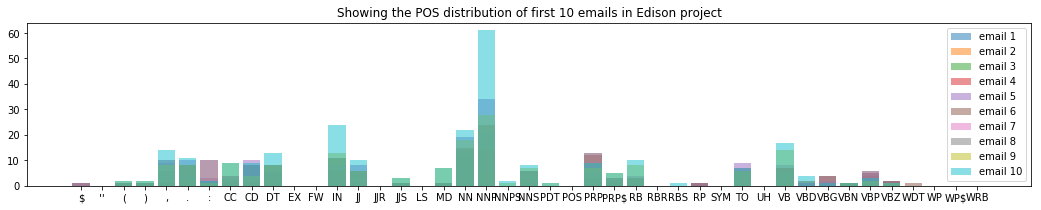

In [27]:
nb_top = 10
plt.figure(figsize = (18,3))
for i in range(len(idx_list)):
    row = mat_pos_edison[i,:]
    if row.sum() > 5000:
        continue
    plt.bar(np.arange(0,len(row),1),row, alpha = 0.5, label = 'email {}'.format(i) )
    if i == nb_top:
        break
plt.xticks(np.arange(0,len(row),1), unique_pos_tags)
plt.legend()
plt.title('Showing the POS distribution of first {} emails in Edison project'.format(nb_top))
plt.show()

In [28]:
# some emails are extremely long. I put them in a list for further use
long_email_idx_list = []
for i in range(len(idx_list)):
    row = mat_pos_edison[i,:]
    if row.sum() > 5000:
        long_email_idx_list.append(i)
long_email_idx_list

[0, 854, 1008, 1010, 1018, 1022]

In [29]:
# get propotion of pos in each email
m,n = mat_pos_edison.shape
mat_pos_edison_normed = np.zeros_like(mat_pos_edison)
for i in range(m):
    if mat_pos_edison[i,:].sum() != 0:
        mat_pos_edison_normed[i,:] = mat_pos_edison[i,:]/mat_pos_edison[i,:].sum()

In [30]:
df_pos_edison_normed = pd.DataFrame(mat_pos_edison_normed, columns=unique_pos_tags)
df_pos_edison_normed.head()

,$,'',(,),",",.,:,CC,CD,DT,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0.000038,0.0,0.003051,0.003051,0.102468,0.022905,0.022226,0.022565,0.033490,0.052703,...,0.018007,0.011377,0.016274,0.015483,0.015031,0.008476,0.003767,0.002976,0.0,0.001582
1,0.007874,0.0,0.000000,0.000000,0.047244,0.031496,0.007874,0.015748,0.062992,0.062992,...,0.055118,0.015748,0.031496,0.007874,0.039370,0.015748,0.000000,0.000000,0.0,0.000000
2,0.007874,0.0,0.000000,0.000000,0.047244,0.031496,0.007874,0.015748,0.062992,0.062992,...,0.055118,0.015748,0.031496,0.007874,0.039370,0.015748,0.000000,0.000000,0.0,0.000000
3,0.000000,0.0,0.010638,0.010638,0.010638,0.085106,0.021277,0.021277,0.021277,0.042553,...,0.063830,0.000000,0.000000,0.010638,0.031915,0.021277,0.000000,0.000000,0.0,0.000000
4,0.000000,0.0,0.009524,0.009524,0.009524,0.076190,0.019048,0.038095,0.019048,0.047619,...,0.066667,0.000000,0.009524,0.009524,0.038095,0.019048,0.000000,0.000000,0.0,0.000000


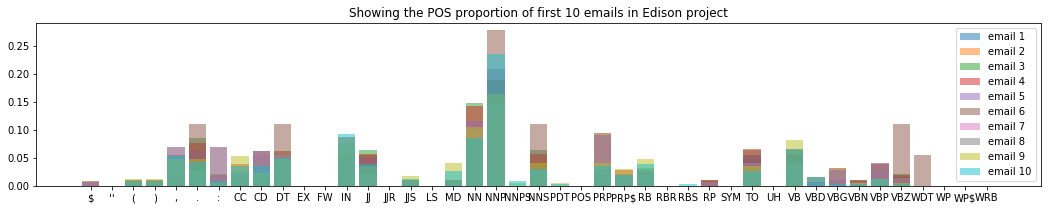

In [31]:
nb_top = 10
plt.figure(figsize = (18,3))
for i in range(len(idx_list)):
    row = mat_pos_edison_normed[i,:]
    if i in long_email_idx_list:
        continue
    plt.bar(np.arange(0,len(row),1),row, alpha = 0.5, label = 'email {}'.format(i) )
    if i == nb_top:
        break
plt.xticks(np.arange(0,len(row),1), unique_pos_tags)
plt.legend()
plt.title('Showing the POS proportion of first {} emails in Edison project'.format(nb_top))
plt.show()

## Find the most different email by comparing the distance of POS vector for each email and the average vector

In [32]:
proportion_dists = []
proportion_mean = mat_pos_edison_normed.mean(axis=0)
for i in range(len(idx_list)):
#     if i in long_email_idx_list:
#         proportion_dists.append(-1)
#         continue
    row = mat_pos_edison_normed[i,:]
    proportion_dists.append(np.linalg.norm(proportion_mean-row))
proportion_dists = np.array(proportion_dists)
proportion_dists.max()

0.9850081992391401

In [33]:
proportion_dists.argmax()

115

In [34]:
df.iloc[115]['Body']

"['', 'Thank you Sheila for your kind words. We have been blessed with great friends and clients that make our jobs a real joy. You and the Foundation are both to our agency. The credit goes to the team we have had for a long time over here that does a fantastic job.', '', 'Thank you for all that you and your Board does not only for our schools but for the community as a whole. The work all of you do inspires so many of us!', '', '']"